# Compare Wiki Summary and NIST Assessors

This copies our assessment against whole-event summaries from CrisisFACTS 2022.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import json
import glob
import gzip

import scipy.stats

import matplotlib.pyplot as plt

In [3]:
from torchmetrics.text.rouge import ROUGEScore

import bert_score

bert_score.__version__

'0.3.12'

In [17]:
summaries = pd.read_json("CrisisFACTs-2022to2023.topics.withSummaries.json")

In [24]:
summaries

,trecisID,dataset,title,type,url,description,wiki.summary,nist.summary
CrisisFACTS-001,TRECIS-CTIT-H-092,2017_12_07_lilac_wildfire.2017,Lilac Wildfire 2017,Wildfire,https://en.wikipedia.org/wiki/Lilac_Fire,The Lilac Fire was a fire that burned in north...,The Lilac Fire was a fire that burned in north...,Wind gusts have been recorded at 40-50 mph in ...
CrisisFACTS-002,TRECIS-CTIT-H-095,2018_07_23_cranston_wildfire.2018,Cranston Wildfire 2018,Wildfire,https://en.wikipedia.org/wiki/Cranston_Fire,The Cranston Fire was a wildfire that burned i...,The Cranston Fire was a wildfire that burned i...,An evacuation center had been set up at Bannin...
CrisisFACTS-003,TRECIS-CTIT-H-097,2018_08_05_holy_wildfire.2018,Holy Wildfire 2018,Wildfire,https://en.wikipedia.org/wiki/Holy_Fire_(2018),The Holy Fire was a wildfire that burned in th...,The Holy Fire was a wildfire that burned in th...,The Holy Fire in California has forced the clo...
CrisisFACTS-004,TRECIS-CTIT-H-098,2018_09_07_hurricane_florence.2018,Hurricane Florence 2018,Hurricane,https://en.wikipedia.org/wiki/Hurricane_Florence,Hurricane Florence was a powerful and long-liv...,Hurricane Florence was a powerful and long-liv...,The hurricane has made landfall in the Carolin...
CrisisFACTS-005,TRECIS-CTIT-H-101,2018_maryland_flood,2018 Maryland Flood,Flood,https://en.wikipedia.org/wiki/2018_Maryland_flood,"In the afternoon of May 27, 2018, after over 8...","In the afternoon of May 27, 2018, after over 8...",Officials evacuated the area due to a gas leak...
CrisisFACTS-006,TRECIS-CTIT-H-106,2019_10_10_saddleridge_wildfire.2019,Saddleridge Wildfire 2019,Wildfire,https://en.wikipedia.org/wiki/Saddleridge_Fire,The Saddleridge Fire was a wildfire burning ne...,The Saddleridge Fire was a wildfire burning ne...,"4,500 customers in Los Angeles and surrounding..."
CrisisFACTS-007,TRECIS-CTIT-H-113,2020_08_27_hurricane_laura.2020,Hurricane Laura 2020,Hurricane,https://en.wikipedia.org/wiki/Hurricane_Laura,Hurricane Laura was a deadly and destructive C...,Hurricane Laura was a deadly and destructive C...,Hurricane force winds amp catastrophic storm s...
CrisisFACTS-008,TRECIS-CTIT-H-114,2020_09_11_hurricane_sally.2020,Hurricane Sally 2020,Hurricane,https://en.wikipedia.org/wiki/Hurricane_Sally,Hurricane Sally was a destructive Atlantic hur...,Hurricane Sally was a destructive and slow-mov...,Railways have not closed. Tropical Storm Sally...
CrisisFACTS-009,TRECIS-CTIT-H-066,beirutExplosion2020,Beirut Explosion,Accident,https://en.wikipedia.org/wiki/2020_Beirut_expl...,"On 4 August 2020, a large amount of ammonium n...","On 4 August 2020, a large amount of ammonium n...",The impact of the afternoon blast was felt in ...
CrisisFACTS-010,TRECIS-CTIT-H-076,2020_01_27_houston_explosion.2020,Houston Explosion 2020,Accident,https://en.wikipedia.org/wiki/2020_Houston_exp...,"On January 24, 2020, a building at Watson Grin...","On January 24, 2020, a building at Watson Grin...",Massive fire rips through building near Housto...


In [19]:
targets = ["wiki.summary", "nist.summary"]

In [21]:
rouge = ROUGEScore(
    use_stemmer=True,
    rouge_keys=("rouge2",)
)

In [22]:
target_pairs = []
for t1 in targets:
    for t2 in targets:
        if t1 == t2:
            continue
        target_pairs.append((t1, t2))
        
target_pairs

[('wiki.summary', 'nist.summary'), ('nist.summary', 'wiki.summary')]

In [63]:
rows = []

for event_id,row in summaries.iterrows():
    print(event_id)


    for t1,t2 in target_pairs[:1]:
        print("\t", t1, t2)
            
        metric = rouge(row[t1], row[t2])
        bert_metric = bert_score.score(
            [row[t1]], 
            [row[t2]], 
            model_type="microsoft/deberta-xlarge-mnli"
        )
        
        metric.update({
            "bertscore_precision": bert_metric[0],
            "bertscore_recall": bert_metric[1],
            "bertscore_fmeasure": bert_metric[2],
        })
        

        this_metric_rows = [{
            "metric":k, 
            "value":v.item(), 
            "event": event_id,
            "target": "%s->%s" % (t1,t2)
        } for k,v in metric.items()]
        this_row_df = pd.DataFrame(this_metric_rows)
        rows.append(this_row_df)
    


CrisisFACTS-001
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-002
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-003
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-004
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-005
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-006
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-007
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-008
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-009
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-010
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-011
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-012
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-013
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-014
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-015
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-016
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-017
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

CrisisFACTS-018
	 wiki.summary nist.summary


Some weights of the model checkpoint at microsoft/deberta-xlarge-mnli were not used when initializing DebertaModel: ['pooler.dense.weight', 'pooler.dense.bias', 'classifier.bias', 'classifier.weight']
- This IS expected if you are initializing DebertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/cbuntain/.local/lib/python3.9/site-packages/transformers/models/deberta/modeling_deberta.py:679: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  query_layer = query_layer / torch.tens

In [64]:
all_df = pd.concat(rows)
all_df

,metric,value,event,target
0,rouge2_fmeasure,0.024010,CrisisFACTS-001,wiki.summary->nist.summary
1,rouge2_precision,0.277778,CrisisFACTS-001,wiki.summary->nist.summary
2,rouge2_recall,0.012547,CrisisFACTS-001,wiki.summary->nist.summary
3,bertscore_precision,0.590926,CrisisFACTS-001,wiki.summary->nist.summary
4,bertscore_recall,0.520302,CrisisFACTS-001,wiki.summary->nist.summary
...,...,...,...,...
1,rouge2_precision,0.320611,CrisisFACTS-018,wiki.summary->nist.summary
2,rouge2_recall,0.010742,CrisisFACTS-018,wiki.summary->nist.summary
3,bertscore_precision,0.585559,CrisisFACTS-018,wiki.summary->nist.summary
4,bertscore_recall,0.498592,CrisisFACTS-018,wiki.summary->nist.summary


In [66]:
metric_df = all_df.pivot("event", "metric", "value")

In [74]:
metric_df = metric_df[~metric_df.index.isin(["CrisisFACTS-011", "CrisisFACTS-012"])]

<AxesSubplot:xlabel='bertscore_fmeasure', ylabel='rouge2_fmeasure'>

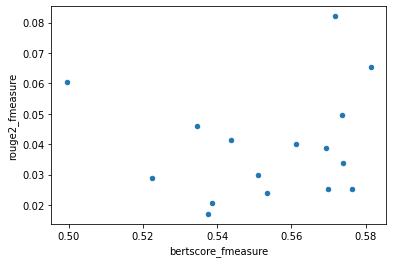

In [75]:
metric_df[["bertscore_fmeasure", "rouge2_fmeasure"]].plot.scatter(x="bertscore_fmeasure", y="rouge2_fmeasure")

In [79]:
metric_df[["bertscore_fmeasure", "rouge2_fmeasure"]].corr()

metric,bertscore_fmeasure,rouge2_fmeasure
metric,,
bertscore_fmeasure,1.00000,0.12324
rouge2_fmeasure,0.12324,1.00000


In [80]:
print(metric_df[["bertscore_fmeasure", "rouge2_fmeasure"]].corr().style.to_latex())

\begin{tabular}{lrr}
metric & bertscore_fmeasure & rouge2_fmeasure \\
metric &  &  \\
bertscore_fmeasure & 1.000000 & 0.123240 \\
rouge2_fmeasure & 0.123240 & 1.000000 \\
\end{tabular}



In [83]:
metric_df[["bertscore_fmeasure", "rouge2_fmeasure"]].mean()

metric
bertscore_fmeasure    0.553641
rouge2_fmeasure       0.039266
dtype: float64